In [98]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import re

In [3]:
x_train_df = pd.read_csv('data_reviews/x_train.csv')
y_train_df = pd.read_csv('data_reviews/y_train.csv')

tr_text_list = x_train_df['text'].values.tolist()

In [4]:
# Special characters and punctuation
df = x_train_df.copy()
punc_list = list("?:!.,;()")
df["text_1"] = df["text"].str.replace("\n", "")
df["text_1"] = df["text_1"].str.replace('"', "")
df["text_1"] = df["text_1"].str.replace("'s", "")
for punc in punc_list:
    df["text_1"] = df["text_1"].str.replace(punc, "")
    
#lowering cases
df["text_1"] = df["text_1"].str.lower()
df.head()

,website_name,text,text_1
0,amazon,Oh and I forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.,that one didn't work either
2,amazon,Waste of 13 bucks.,waste of 13 bucks
3,amazon,"Product is useless, since it does not have eno...",product is useless since it does not have enou...
4,amazon,None of the three sizes they sent with the hea...,none of the three sizes they sent with the hea...


In [5]:
#stemming and lemmatization
# nltk.download('punkt')
# nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    if word == '':
        return ''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['text_1']
    text_words = text.split(" ")
    # Iterate through every word to lemmatize
    for word in text_words:
        pos = get_wordnet_pos(word)
        if pos != '':
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos=pos))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

df['text_2'] = lemmatized_text_list
df.head()

,website_name,text,text_1,text_2
0,amazon,Oh and I forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.,that one didn't work either,that one didn't work either
2,amazon,Waste of 13 bucks.,waste of 13 bucks,waste of 13 buck
3,amazon,"Product is useless, since it does not have eno...",product is useless since it does not have enou...,product be useless since it do not have enough...
4,amazon,None of the three sizes they sent with the hea...,none of the three sizes they sent with the hea...,none of the three size they sent with the head...


In [6]:
#remove numbers
pattern = r'[0-9]'
remove_number = []
for text in df["text_2"].tolist():
    remove_number.append(re.sub(pattern, '', text))
    
df["text_3"] = remove_number
df

,website_name,text,text_1,text_2,text_3
0,amazon,Oh and I forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.,that one didn't work either,that one didn't work either,that one didn't work either
2,amazon,Waste of 13 bucks.,waste of 13 bucks,waste of 13 buck,waste of buck
3,amazon,"Product is useless, since it does not have eno...",product is useless since it does not have enou...,product be useless since it do not have enough...,product be useless since it do not have enough...
4,amazon,None of the three sizes they sent with the hea...,none of the three sizes they sent with the hea...,none of the three size they sent with the head...,none of the three size they sent with the head...
...,...,...,...,...,...
2395,yelp,The sweet potato fries were very good and seas...,the sweet potato fries were very good and seas...,the sweet potato fry be very good and season well,the sweet potato fry be very good and season well
2396,yelp,I could eat their bruschetta all day it is dev...,i could eat their bruschetta all day it is devine,i could eat their bruschetta all day it be devine,i could eat their bruschetta all day it be devine
2397,yelp,Ambience is perfect.,ambience is perfect,ambience be perfect,ambience be perfect
2398,yelp,We ordered the duck rare and it was pink and t...,we ordered the duck rare and it was pink and t...,we order the duck rare and it be pink and tend...,we order the duck rare and it be pink and tend...


In [7]:
list_columns = ["website_name", "text_3"]
df_clean = df.copy()
df_clean = df_clean[list_columns]
df_clean = df_clean.rename(columns={'text_3': 'text'})
df_clean.head()

,website_name,text
0,amazon,oh and i forgot to also mention the weird colo...
1,amazon,that one didn't work either
2,amazon,waste of buck
3,amazon,product be useless since it do not have enough...
4,amazon,none of the three size they sent with the head...


In [8]:
from spellchecker import SpellChecker
spell = SpellChecker(distance=4)
list_words = []
for index, txt in enumerate(df_clean.text):
    words = spell.split_words(txt)
    list_words = [spell.correction(word) for word in words]
    df_clean.loc[index, 'text'] = ' '.join(list_words)

In [9]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
to_remove = ['against', 'into', 'above', 'below', 'up', 'down', 'on', 'off', 'again', 'few', 'more', 'most', 'no', 'not', 'only', 'same']
for word in to_remove:
    stop_words.remove(word)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irenechang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 2, stop_words = stop_words)
vectors = vectorizer.fit_transform(df_clean['text'].values.tolist())
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

# all_important_words3 = []
# for index, item in enumerate(denselist3):
#     scores3 = {feature: tfidf for feature, tfidf in zip(feature_names3, item)}
#     sorted_words3 = sorted(scores3.items(), key=lambda x: x[1], reverse=True)
#     for word, score in sorted_words3: 
#         if score > 2:
#             all_important_words3.append((word, score))

In [12]:
vectorizer2 = TfidfVectorizer(min_df = 2)
vectors2 = vectorizer2.fit_transform(df_clean['text'].values.tolist())
feature_names2 = vectorizer2.get_feature_names()
dense2 = vectors2.todense()
denselist2 = dense2.tolist()

feature_names2 = vectorizer2.get_feature_names()
trainset2 = pd.DataFrame(denselist2, columns=feature_names2)

# with stopwords
x_train2, x_test2, y_train2, y_test2 = train_test_split(trainset2, y_train_df['is_positive_sentiment'], test_size=0.33, random_state = 0)

In [180]:
feature_names = vectorizer.get_feature_names()
trainset = pd.DataFrame(denselist, columns=feature_names)

# without stopwords
x_train, x_test, y_train, y_test = train_test_split(trainset, y_train_df['is_positive_sentiment'], test_size=0.33, random_state = 0)

In [174]:
trainset2.to_csv('important_words.csv', index=False)

## LR TFIDF Unigram Without Stopwords (currently best model)

In [84]:
# logistic regression with stopwords
# 0.9347014925373134
# 0.7714646464646465

In [72]:
# logistic regression without stopwords
base_lr = LogisticRegression()
base_lr.fit(x_train, y_train)
print(base_lr.score(x_train, y_train))
print(base_lr.score(x_test, y_test))

0.9371890547263682
0.7992424242424242


In [78]:
param_grid = {"C":np.logspace(-3,3,10), "max_iter":[50, 150, 250, 350, 450, 500]}
tune_lr = LogisticRegression()
grid_search = RandomizedSearchCV(tune_lr, param_distributions = param_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                                        'max_iter': [50, 150, 250, 350, 450,
                                                     500]},
                   scoring='accuracy', verbose=1)

In [79]:
print('Best parameters found:\n', grid_search.best_params_)
print("Train accuracy: %.4f" % grid_search.score(x_train, y_train))
print(" Test accuracy: %.4f" % grid_search.score(x_test, y_test))

Best parameters found:
 {'max_iter': 250, 'C': 2.154434690031882}
Train accuracy: 0.9515
 Test accuracy: 0.8056


In [91]:
# print('Best parameters found:\n', grid_search.best_params_)
# print("Train accuracy: %.4f" % grid_search.score(x_train2, y_train2))
# print(" Test accuracy: %.4f" % grid_search.score(x_test2, y_test2))
# Best parameters found:
#  {'max_iter': 500, 'C': 2.154434690031882}
# Train accuracy: 0.9527
#  Test accuracy: 0.7866

In [90]:

def plot_accuracy_and_logLoss(range, train_acc, test_acc, train_logLoss, test_logLoss):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].plot(range, train_acc, color="red", label="train")
    ax[0].plot(range, test_acc, color="blue", label="test")
    ax[0].legend()
    ax[0].set_xlabel('C values')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(range, train_logLoss, color="red", label="train")
    ax[1].plot(range, test_logLoss, color="blue", label="test")
    ax[1].legend()
    ax[1].set_xlabel('C values')
    ax[1].set_ylabel('Log loss')
    plt.show()

def examine_Cs(data_train, label_train):
    train_acc = []
    test_acc = []
    train_logLoss = []
    test_logLoss = []
    for c in np.logspace(-1,1,10):
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        train_acc_fold = []
        test_acc_fold = []
        train_logLoss_fold = []
        test_logLoss_fold = []
        for train_index, test_index in kf.split(data_train):
            X_train, X_test = data_train.loc[train_index], data_train.loc[test_index]
            y_train, y_test = label_train[train_index], label_train[test_index]
            lr = LogisticRegression(C = c)
            lr.fit(X_train, y_train)

            train_acc_fold.append(lr.score(X_train, y_train))
            test_acc_fold.append(lr.score(X_test, y_test))
            train_logLoss_fold.append(log_loss(y_train, lr.predict(X_train)))
            test_logLoss_fold.append(log_loss(y_test, lr.predict(X_test)))
        print("C value: %0.3f" % c)
        print("Training accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in train_acc_fold), "Mean: ", '%0.3f'%np.mean(train_acc_fold), 
        "Std: ", '%0.3f'%np.std(train_acc_fold))
        print("Testing accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in test_acc_fold), "Mean: ", '%0.3f'%np.mean(test_acc_fold), 
        "Std: ", '%0.3f'%np.std(test_acc_fold))
        print("Training log loss for 4 folds are: ", " ".join('%0.3f'%x for x in train_logLoss_fold), "Mean: ", '%0.3f'%np.mean(train_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(train_logLoss_fold))
        print("Testing log loss for 4 folds are: ", " ".join('%0.3f'%x for x in test_logLoss_fold), "Mean: ", '%0.3f'%np.mean(test_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(test_logLoss_fold), "\n")
        
        train_acc.append(sum(train_acc_fold)/4)
        test_acc.append(sum(test_acc_fold)/4)
        train_logLoss.append(sum(train_logLoss_fold)/4)
        test_logLoss.append(sum(test_logLoss_fold)/4)
    # plot_accuracy_and_logLoss(np.logspace(-1,1,10), train_acc, test_acc, train_logLoss, test_logLoss)

In [ ]:
examine_Cs(trainset, y_train_df['is_positive_sentiment'])

In [92]:
def plot_accuracy_and_logLoss(range, train_acc, test_acc, train_logLoss, test_logLoss):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].plot(range, train_acc, color="red", label="train")
    ax[0].plot(range, test_acc, color="blue", label="test")
    ax[0].legend()
    ax[0].set_xlabel('Max iterations')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(range, train_logLoss, color="red", label="train")
    ax[1].plot(range, test_logLoss, color="blue", label="test")
    ax[1].legend()
    ax[1].set_xlabel('Max_iterations')
    ax[1].set_ylabel('Log loss')
    plt.show()

def examine_max_iters(data_train, label_train):
    train_acc = []
    test_acc = []
    train_logLoss = []
    test_logLoss = []
    for m in [10, 50, 100, 150, 200, 250, 300, 350]:
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        train_acc_fold = []
        test_acc_fold = []
        train_logLoss_fold = []
        test_logLoss_fold = []
        for train_index, test_index in kf.split(data_train):
            X_train, X_test = data_train.loc[train_index], data_train.loc[test_index]
            y_train, y_test = label_train[train_index], label_train[test_index]
            lr = LogisticRegression(C = 2.154434690031882, max_iter=m)
            lr.fit(X_train, y_train)

            train_acc_fold.append(lr.score(X_train, y_train))
            test_acc_fold.append(lr.score(X_test, y_test))
            train_logLoss_fold.append(log_loss(y_train, lr.predict(X_train)))
            test_logLoss_fold.append(log_loss(y_test, lr.predict(X_test)))
        print("Max iteration: %d" % m)
        print("Training accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in train_acc_fold), "Mean: ", '%0.3f'%np.mean(train_acc_fold), 
        "Std: ", '%0.3f'%np.std(train_acc_fold))
        print("Testing accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in test_acc_fold), "Mean: ", '%0.3f'%np.mean(test_acc_fold), 
        "Std: ", '%0.3f'%np.std(test_acc_fold))
        print("Training log loss for 4 folds are: ", " ".join('%0.3f'%x for x in train_logLoss_fold), "Mean: ", '%0.3f'%np.mean(train_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(train_logLoss_fold))
        print("Testing log loss for 4 folds are: ", " ".join('%0.3f'%x for x in test_logLoss_fold), "Mean: ", '%0.3f'%np.mean(test_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(test_logLoss_fold), "\n")

        # train_acc.append(sum(train_acc_fold)/4)
        # test_acc.append(sum(test_acc_fold)/4)
        # train_logLoss.append(sum(train_logLoss_fold)/4)
        # test_logLoss.append(sum(test_logLoss_fold)/4)
    # plot_accuracy_and_logLoss([10, 50, 100, 150, 200, 250, 300, 350], train_acc, test_acc, train_logLoss, test_logLoss)

In [ ]:
examine_max_iters(trainset, y_train_df['is_positive_sentiment'])

In [81]:
test_set = pd.read_csv('test_data.csv')
prediction = grid_search.predict_proba(test_set)[:,1]
np.savetxt('yproba1_test.txt', prediction)

## SVM TFIDF Unigram with stopwords

In [85]:
from sklearn.svm import SVC

base_svm = SVC()
base_svm.fit(x_train2, y_train2)
print(base_svm.score(x_train2, y_train2))
print(base_svm.score(x_test2, y_test2))

0.9925373134328358
0.7929292929292929


In [86]:
# base_svm = SVC()
# base_svm.fit(x_train, y_train)
# print(base_svm.score(x_train, y_train))
# print(base_svm.score(x_test, y_test))
# 0.9912935323383084
# 0.7941919191919192

In [163]:
tune_svc = SVC(random_state = 0, probability=True)
svc_search = RandomizedSearchCV(tune_svc, param_distributions = svc_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
svc_search.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(probability=True, random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   scoring='accuracy', verbose=1)

In [164]:
print('Best parameters found:\n', svc_search.best_params_)
print("Train accuracy: %.4f" % svc_search.score(x_train, y_train))
print(" Test accuracy: %.4f" % svc_search.score(x_test, y_test))
# Best parameters found:
#  {'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.001}
# Train accuracy: 0.9988
#  Test accuracy: 0.7879

Best parameters found:
 {'kernel': 'poly', 'gamma': 100, 'degree': 1, 'C': 0.01}
Train accuracy: 0.9496
 Test accuracy: 0.7929


In [170]:
def plot_accuracy_and_logLoss(range, train_acc, test_acc, train_logLoss, test_logLoss):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].plot(range, train_acc, color="red", label="train")
    ax[0].plot(range, test_acc, color="blue", label="test")
    ax[0].legend()
    ax[0].set_xlabel('C values')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(range, train_logLoss, color="red", label="train")
    ax[1].plot(range, test_logLoss, color="blue", label="test")
    ax[1].legend()
    ax[1].set_xlabel('C values')
    ax[1].set_ylabel('Log loss')
    plt.show()

def examine_Cs(data_train, label_train):
    train_acc = []
    test_acc = []
    train_logLoss = []
    test_logLoss = []
    for c in np.logspace(-3, -1, 10):
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        train_acc_fold = []
        test_acc_fold = []
        train_logLoss_fold = []
        test_logLoss_fold = []
        for train_index, test_index in kf.split(data_train):
            X_train, X_test = data_train.loc[train_index], data_train.loc[test_index]
            y_train, y_test = label_train[train_index], label_train[test_index]
            svc = SVC(kernel='poly', gamma=100, degree=1, C = c)
            svc.fit(X_train, y_train)

            train_acc_fold.append(svc.score(X_train, y_train))
            test_acc_fold.append(svc.score(X_test, y_test))
            train_logLoss_fold.append(log_loss(y_train, svc.predict(X_train)))
            test_logLoss_fold.append(log_loss(y_test, svc.predict(X_test)))
        print("C value: %0.4f" % c)
        print("Training accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in train_acc_fold), "Mean: ", '%0.3f'%np.mean(train_acc_fold), 
        "Std: ", '%0.3f'%np.std(train_acc_fold))
        print("Testing accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in test_acc_fold), "Mean: ", '%0.3f'%np.mean(test_acc_fold), 
        "Std: ", '%0.3f'%np.std(test_acc_fold))
        print("Training log loss for 4 folds are: ", " ".join('%0.3f'%x for x in train_logLoss_fold), "Mean: ", '%0.3f'%np.mean(train_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(train_logLoss_fold))
        print("Testing log loss for 4 folds are: ", " ".join('%0.3f'%x for x in test_logLoss_fold), "Mean: ", '%0.3f'%np.mean(test_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(test_logLoss_fold), "\n")
        
        train_acc.append(sum(train_acc_fold)/4)
        test_acc.append(sum(test_acc_fold)/4)
        train_logLoss.append(sum(train_logLoss_fold)/4)
        test_logLoss.append(sum(test_logLoss_fold)/4)
    plot_accuracy_and_logLoss(np.logspace(-3, -1, 10), train_acc, test_acc, train_logLoss, test_logLoss)

C value: 0.0010
Training accuracy scores for 4 folds are:  0.857 0.880 0.828 0.819 Mean:  0.846 Std:  0.024
Testing accuracy scores for 4 folds are:  0.778 0.810 0.763 0.698 Mean:  0.762 Std:  0.041
Training log loss for 4 folds are:  4.931 4.145 5.948 6.255 Mean:  5.320 Std:  0.837
Testing log loss for 4 folds are:  7.656 6.562 8.174 10.419 Mean:  8.203 Std:  1.406 

C value: 0.0017
Training accuracy scores for 4 folds are:  0.895 0.896 0.887 0.884 Mean:  0.890 Std:  0.005
Testing accuracy scores for 4 folds are:  0.800 0.818 0.822 0.758 Mean:  0.800 Std:  0.025
Training log loss for 4 folds are:  3.627 3.588 3.914 4.010 Mean:  3.785 Std:  0.181
Testing log loss for 4 folds are:  6.908 6.275 6.159 8.347 Mean:  6.922 Std:  0.871 

C value: 0.0028
Training accuracy scores for 4 folds are:  0.911 0.909 0.904 0.903 Mean:  0.907 Std:  0.003
Testing accuracy scores for 4 folds are:  0.813 0.827 0.828 0.785 Mean:  0.813 Std:  0.017
Training log loss for 4 folds are:  3.070 3.128 3.300 3.358 

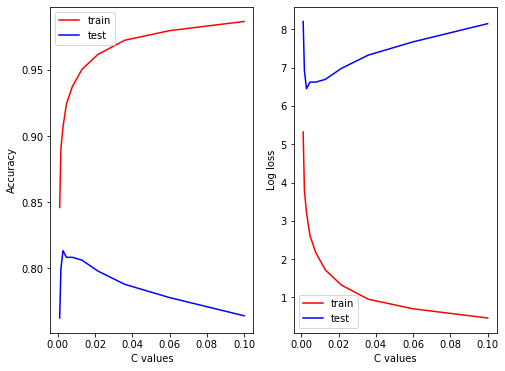

In [171]:
examine_Cs(trainset, y_train_df['is_positive_sentiment'])

#### 2. Next

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
C = [.0001, .001, .01]
gamma = [.001, .01, .1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear', 'rbf', 'poly']

svc_grid = {'C':C,
    'kernel': kernel,
              'gamma': gamma,
              'degree': degree
             }

tune_svc = SVC(random_state = 0, probability=True)
svc_search = RandomizedSearchCV(tune_svc, param_distributions = svc_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
svc_search.fit(x_train2, y_train2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(probability=True, random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   scoring='accuracy', verbose=1)

In [51]:
print('Best parameters found:\n', svc_search.best_params_)
print("Train accuracy: %.4f" % svc_search.score(x_train2, y_train2))
print(" Test accuracy: %.4f" % svc_search.score(x_test2, y_test2))

Best parameters found:
 {'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.001}
Train accuracy: 0.9994
 Test accuracy: 0.8030


In [165]:
svcf = SVC(kernel='poly', gamma=100, degree=2, C=0.001)
svcf.fit(x_train2, y_train2)
print(svcf.score(x_train2, y_train2))
print(svcf.score(x_test2, y_test2))

0.9993781094527363
0.803030303030303


In [172]:
def plot_accuracy_and_logLoss(range, train_acc, test_acc, train_logLoss, test_logLoss):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].plot(range, train_acc, color="red", label="train")
    ax[0].plot(range, test_acc, color="blue", label="test")
    ax[0].legend()
    ax[0].set_xlabel('Coef0 values')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(range, train_logLoss, color="red", label="train")
    ax[1].plot(range, test_logLoss, color="blue", label="test")
    ax[1].legend()
    ax[1].set_xlabel('Coef0 values')
    ax[1].set_ylabel('Log loss')
    plt.show()

def examine_Cs(data_train, label_train):
    train_acc = []
    test_acc = []
    train_logLoss = []
    test_logLoss = []
    for c in np.logspace(-1, 1.5, 10):
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        train_acc_fold = []
        test_acc_fold = []
        train_logLoss_fold = []
        test_logLoss_fold = []
        for train_index, test_index in kf.split(data_train):
            X_train, X_test = data_train.loc[train_index], data_train.loc[test_index]
            y_train, y_test = label_train[train_index], label_train[test_index]
            svc = SVC(kernel='poly', gamma=100, degree=2, C = 0.00068129, coef0 = c)
            svc.fit(X_train, y_train)

            train_acc_fold.append(svc.score(X_train, y_train))
            test_acc_fold.append(svc.score(X_test, y_test))
            train_logLoss_fold.append(log_loss(y_train, svc.predict(X_train)))
            test_logLoss_fold.append(log_loss(y_test, svc.predict(X_test)))
        print("Coef0 value: %0.4f" % c)
        print("Training accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in train_acc_fold), "Mean: ", '%0.3f'%np.mean(train_acc_fold), 
        "Std: ", '%0.3f'%np.std(train_acc_fold))
        print("Testing accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in test_acc_fold), "Mean: ", '%0.3f'%np.mean(test_acc_fold), 
        "Std: ", '%0.3f'%np.std(test_acc_fold))
        print("Training log loss for 4 folds are: ", " ".join('%0.3f'%x for x in train_logLoss_fold), "Mean: ", '%0.3f'%np.mean(train_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(train_logLoss_fold))
        print("Testing log loss for 4 folds are: ", " ".join('%0.3f'%x for x in test_logLoss_fold), "Mean: ", '%0.3f'%np.mean(test_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(test_logLoss_fold), "\n")
        
        train_acc.append(sum(train_acc_fold)/4)
        test_acc.append(sum(test_acc_fold)/4)
        train_logLoss.append(sum(train_logLoss_fold)/4)
        test_logLoss.append(sum(test_logLoss_fold)/4)
    plot_accuracy_and_logLoss(np.logspace(-1, 1.5, 10), train_acc, test_acc, train_logLoss, test_logLoss)

In [160]:
np.logspace(-4,-1.5,10)

array([0.0001    , 0.00018957, 0.00035938, 0.00068129, 0.00129155,
       0.00244844, 0.00464159, 0.00879923, 0.01668101, 0.03162278])

Coef0 value: 0.1000
Training accuracy scores for 4 folds are:  0.999 1.000 0.999 0.999 Mean:  0.999 Std:  0.000
Testing accuracy scores for 4 folds are:  0.805 0.827 0.845 0.823 Mean:  0.825 Std:  0.014
Training log loss for 4 folds are:  0.019 0.000 0.038 0.019 Mean:  0.019 Std:  0.014
Testing log loss for 4 folds are:  6.735 5.987 5.354 6.102 Mean:  6.044 Std:  0.490 

Coef0 value: 0.1896
Training accuracy scores for 4 folds are:  0.999 1.000 0.999 0.999 Mean:  0.999 Std:  0.000
Testing accuracy scores for 4 folds are:  0.805 0.827 0.845 0.823 Mean:  0.825 Std:  0.014
Training log loss for 4 folds are:  0.019 0.000 0.038 0.019 Mean:  0.019 Std:  0.014
Testing log loss for 4 folds are:  6.735 5.987 5.354 6.102 Mean:  6.044 Std:  0.490 

Coef0 value: 0.3594
Training accuracy scores for 4 folds are:  0.999 1.000 0.999 0.999 Mean:  0.999 Std:  0.000
Testing accuracy scores for 4 folds are:  0.807 0.828 0.845 0.823 Mean:  0.826 Std:  0.014
Training log loss for 4 folds are:  0.019 0.000 0

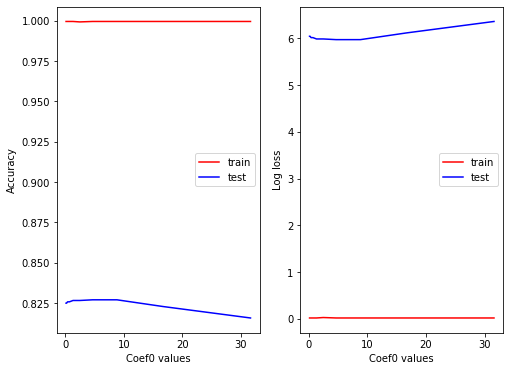

In [173]:
examine_Cs(trainset2, y_train_df['is_positive_sentiment'])

In [177]:
svcc = SVC(kernel='poly', gamma=100, degree=2, C = 0.00068129, coef0 = 2.4484, probability=True)
svcc.fit(x_train2, y_train2)

SVC(C=0.00068129, coef0=2.4484, degree=2, gamma=100, kernel='poly',
    probability=True)

In [178]:
test_set = pd.read_csv('test_data.csv')
prediction = svcc.predict_proba(test_set)[:,1]
np.savetxt('yproba1_test.txt', prediction)

## MLP TFIDF Unigram without stopwords

In [195]:
len(x_test)

792

In [110]:
network = MLPClassifier(max_iter=400, random_state=0, early_stopping=True)
network.fit(x_train, y_train)
print("Train accuracy: %.4f" % network.score(x_train, y_train))
print(" Test accuracy: %.4f" % network.score(x_test, y_test))

Train accuracy: 0.9210
 Test accuracy: 0.7727


In [111]:
try_params = {
    'activation': ['logistic', 'relu', 'identity', 'tanh'],
    'hidden_layer_sizes': [(50,), (100,), (128, 64, 32, 8)],
    'alpha': np.logspace(-2, 2, 10),
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'solver': ['lbfgs', 'adam', 'sgd']
}
network = MLPClassifier(max_iter=400, random_state=0, early_stopping=True)
gscv = RandomizedSearchCV(network, param_distributions = try_params, cv=3, n_jobs=-1, n_iter=50)
gscv.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(early_stopping=True, max_iter=400,
                                           random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['logistic', 'relu',
                                                       'identity', 'tanh'],
                                        'alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (128, 64, 32,
                                                                8)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                               

In [112]:
print('Best parameters found:\n', gscv.best_params_)
print("Train accuracy: %.4f" % gscv.score(x_train, y_train))
print(" Test accuracy: %.4f" % gscv.score(x_test, y_test))

Best parameters found:
 {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 12.915496650148826, 'activation': 'relu'}
Train accuracy: 0.9515
 Test accuracy: 0.8030


In [114]:
best_mlp = gscv.best_estimator_
best_mlp

MLPClassifier(alpha=12.915496650148826, early_stopping=True, max_iter=400,
              random_state=0, solver='lbfgs')

In [131]:

def plot_accuracy_and_logLoss(range, train_acc, test_acc, train_logLoss, test_logLoss):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].plot(range, train_acc, color="red", label="train")
    ax[0].plot(range, test_acc, color="blue", label="test")
    ax[0].legend()
    ax[0].set_xlabel('Tolerance values')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(range, train_logLoss, color="red", label="train")
    ax[1].plot(range, test_logLoss, color="blue", label="test")
    ax[1].legend()
    ax[1].set_xlabel('Tolerance values')
    ax[1].set_ylabel('Log loss')
    plt.show()

def examine_tols(data_train, label_train):
    train_acc = []
    test_acc = []
    train_logLoss = []
    test_logLoss = []
    for t in np.logspace(-3,-1,10):
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        train_acc_fold = []
        test_acc_fold = []
        train_logLoss_fold = []
        test_logLoss_fold = []
        for train_index, test_index in kf.split(data_train):
            X_train, X_test = data_train.loc[train_index], data_train.loc[test_index]
            y_train, y_test = label_train[train_index], label_train[test_index]
            mlp = MLPClassifier(max_iter=400, random_state=0, early_stopping=True, solver='lbfgs', learning_rate= 'constant', hidden_layer_sizes=(100,), activation='relu', 
            alpha=14.67799268, tol = t)
            mlp.fit(X_train, y_train)

            train_acc_fold.append(mlp.score(X_train, y_train))
            test_acc_fold.append(mlp.score(X_test, y_test))
            train_logLoss_fold.append(log_loss(y_train, mlp.predict(X_train)))
            test_logLoss_fold.append(log_loss(y_test, mlp.predict(X_test)))
        print("Tolerance value: %0.4f" % t)
        print("Training accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in train_acc_fold), "Mean: ", '%0.3f'%np.mean(train_acc_fold), 
        "Std: ", '%0.3f'%np.std(train_acc_fold))
        print("Testing accuracy scores for 4 folds are: ", " ".join('%0.3f'%x for x in test_acc_fold), "Mean: ", '%0.3f'%np.mean(test_acc_fold), 
        "Std: ", '%0.3f'%np.std(test_acc_fold))
        print("Training log loss for 4 folds are: ", " ".join('%0.3f'%x for x in train_logLoss_fold), "Mean: ", '%0.3f'%np.mean(train_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(train_logLoss_fold))
        print("Testing log loss for 4 folds are: ", " ".join('%0.3f'%x for x in test_logLoss_fold), "Mean: ", '%0.3f'%np.mean(test_logLoss_fold), 
        "Std: ", '%0.3f'%np.std(test_logLoss_fold), "\n")
        
        train_acc.append(sum(train_acc_fold)/4)
        test_acc.append(sum(test_acc_fold)/4)
        train_logLoss.append(sum(train_logLoss_fold)/4)
        test_logLoss.append(sum(test_logLoss_fold)/4)
    plot_accuracy_and_logLoss(np.logspace(-3,-1,10), train_acc, test_acc, train_logLoss, test_logLoss)

In [ ]:
examine_tols(trainset, y_train_df['is_positive_sentiment'])

In [182]:
mlp = MLPClassifier(max_iter=400, random_state=0, early_stopping=True, solver='lbfgs', learning_rate= 'constant', hidden_layer_sizes=(100,), activation='relu', 
            alpha=14.67799268, tol = 1e-3)
mlp.fit(x_train, y_train)

MLPClassifier(alpha=14.67799268, early_stopping=True, max_iter=400,
              random_state=0, solver='lbfgs', tol=0.001)

In [198]:
test_pred = mlp.predict(x_test)
idx = x_test[test_pred != y_test].index
wrong = x_train_df.loc[idx,]

In [199]:
for i, text in enumerate(wrong['text']):
    print(text)


Not to mention the combination of pears, almonds and bacon is a big winner!
Perfect for someone (me) who only likes beer ice cold, or in this case, even colder.
Steer clear of this product and go with the genuine Palm replacementr pens, which come in a three-pack.
Small, sleek, impressive looking, practical setup with ample storage in place.
This place should honestly be blown up.
Magical Help.
The descriptions said "yum yum sauce" and another said "eel sauce", yet another said "spicy mayo"...well NONE of the rolls had sauces on them.
Someone shouldve invented this sooner.
The color is even prettier than I thought it would be, and the graphics are incredibly sharp.
We'd definitely go back here again.
I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
If it was to turn my good day feeling into a night of disturbing memories than I guess he succeeded.  
The only place good for this film is in the garbage.  
Unless you're just out to visual

In [135]:
test_set = pd.read_csv('test_data.csv')
prediction = mlp.predict_proba(test_set)[:,1]
np.savetxt('yproba1_test.txt', prediction)

In [122]:
np.logspace(1,1.5,10)

array([10.        , 11.36463666, 12.91549665, 14.67799268, 16.68100537,
       18.95735652, 21.5443469 , 24.48436747, 27.82559402, 31.6227766 ])

In [109]:
# from sklearn.neural_network import MLPClassifier

# network2 = MLPClassifier(max_iter=400, random_state=0, early_stopping=True)
# network2.fit(x_train2, y_train2)
# print("Train accuracy: %.4f" % network2.score(x_train2, y_train2))
# print(" Test accuracy: %.4f" % network2.score(x_test2, y_test2))
# Train accuracy: 0.9248
#  Test accuracy: 0.7955

Train accuracy: 0.9565
 Test accuracy: 0.7879


In [106]:
# network2 = MLPClassifier(max_iter=400, random_state=0, early_stopping=True)
# gscv2 = RandomizedSearchCV(network2, param_distributions = try_params, cv=3, n_jobs=-1, n_iter=50)
# gscv2.fit(x_train2, y_train2)

RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(early_stopping=True, max_iter=400,
                                           random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['logistic', 'relu',
                                                       'identity', 'tanh'],
                                        'alpha': array([100. ,  10. ,   1. ,   0.1]),
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (128, 64, 32,
                                                                8)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'solver': ['lbfgs', 'adam', 'sgd']})

In [107]:
# print('Best parameters found:\n', gscv2.best_params_)
# print("Train accuracy: %.4f" % gscv2.score(x_train2, y_train2))
# print(" Test accuracy: %.4f" % gscv2.score(x_test2, y_test2))
# Best parameters found:
#  {'hidden_layer_sizes': (100,), 'alpha': 1.0, 'activation': 'relu'}
# Train accuracy: 0.8843
#  Test accuracy: 0.7702

Best parameters found:
 {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 10.0, 'activation': 'relu'}
Train accuracy: 0.9608
 Test accuracy: 0.7955


## RF - not great

In [102]:
from sklearn.ensemble import RandomForestClassifier
base_rfc = RandomForestClassifier(random_state = 0)
base_rfc.fit(x_train, y_train)
print(base_rfc.score(x_train, y_train))
print(base_rfc.score(x_test, y_test))

0.9987562189054726
0.773989898989899


In [105]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rfc_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

tune_rfc = RandomForestClassifier(random_state = 0)
rfc_search = RandomizedSearchCV(tune_rfc, param_distributions = rfc_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1)
rfc_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy', verbose=1)

In [106]:
print('Best parameters found:\n', rfc_search.best_params_)
print("Train accuracy: %.4f" % rfc_search.score(x_train, y_train))
print(" Test accuracy: %.4f" % rfc_search.score(x_test, y_test))

Best parameters found:
 {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
Train accuracy: 0.9633
 Test accuracy: 0.7765


In [103]:
from sklearn.ensemble import RandomForestClassifier
base_rfc = RandomForestClassifier(random_state = 0)
base_rfc.fit(x_train2, y_train2)
print(base_rfc.score(x_train2, y_train2))
print(base_rfc.score(x_test2, y_test2))

1.0
0.7613636363636364


## Gradient boostng - not great

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

base_gbc = GradientBoostingClassifier(random_state=8)
base_gbc.fit(x_train, y_train)
print(base_gbc.score(x_train, y_train))
print(base_gbc.score(x_test, y_test))

0.8557213930348259
0.7664141414141414


In [108]:
base_gbc = GradientBoostingClassifier(random_state=8)
base_gbc.fit(x_train2, y_train2)
print(base_gbc.score(x_train2, y_train2))
print(base_gbc.score(x_test2, y_test2))

0.8606965174129353
0.7386363636363636


In [109]:
n_estimators = [200, 800]
max_features = ['auto', 'sqrt']
max_depth = [10, 40]
max_depth.append(None)
min_samples_split = [10, 30, 50]
min_samples_leaf = [1, 2, 4]
learning_rate = [.1, .5]
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}
base_gbc = GradientBoostingClassifier(random_state=8)
random_search = RandomizedSearchCV(estimator=base_gbc,param_distributions=random_grid, n_iter=50, scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=8)
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=8),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5],
                                        'max_depth': [10, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [10, 30, 50],
                                        'n_estimators': [200, 800],
                                        'subsample': [0.5, 1.0]},
                   random_state=8, scoring='accuracy', verbose=1)

In [110]:
print('Best parameters found:\n', random_search.best_params_)
print("Train accuracy: %.4f" % random_search.score(x_train, y_train))
print(" Test accuracy: %.4f" % random_search.score(x_test, y_test))

Best parameters found:
 {'subsample': 1.0, 'n_estimators': 800, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.5}
Train accuracy: 0.9988
 Test accuracy: 0.7891


## LR Bigrams without stopwords

In [111]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 2)
model = tfidf.fit_transform(df_clean['text'].values.tolist())
features = tfidf.get_feature_names()
dnse = model.todense()
dnselist = dnse.tolist()

features = tfidf.get_feature_names()
df = pd.DataFrame(dnselist, columns=features)

# with stopwords
x_train3, x_test3, y_train3, y_test3 = train_test_split(df, y_train_df['is_positive_sentiment'], test_size=0.33, random_state = 0)

In [116]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), min_df = 2, stop_words=stop_words)
model2 = tfidf2.fit_transform(df_clean['text'].values.tolist())
features2 = tfidf2.get_feature_names()
dnse2 = model2.todense()
dnselist2 = dnse2.tolist()

df2 = pd.DataFrame(dnselist2, columns=features2)

# with stopwords
x_train4, x_test4, y_train4, y_test4 = train_test_split(df2, y_train_df['is_positive_sentiment'], test_size=0.33, random_state = 0)

In [123]:
# base_lr = LogisticRegression()
# base_lr.fit(x_train3, y_train3)
# print(base_lr.score(x_train3, y_train3))
# print(base_lr.score(x_test3, y_test3))
# 0.9651741293532339
# 0.7765151515151515

In [117]:
base_lr = LogisticRegression()
base_lr.fit(x_train4, y_train4)
print(base_lr.score(x_train4, y_train4))
print(base_lr.score(x_test4, y_test4))

0.9527363184079602
0.8042929292929293


In [122]:
# param_grid = {"C":np.logspace(-3,3,10), "max_iter":[50, 150, 250, 350, 450, 500]}
# tune_lr3 = LogisticRegression()
# grid_search3 = RandomizedSearchCV(tune_lr3, param_distributions = param_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
# grid_search3.fit(x_train3, y_train3)

In [114]:
# print('Best parameters found:\n', grid_search3.best_params_)
# print("Train accuracy: %.4f" % grid_search3.score(x_train3, y_train3))
# print(" Test accuracy: %.4f" % grid_search3.score(x_test3, y_test3))
# Best parameters found:
#  {'max_iter': 350, 'C': 10.0}
# Train accuracy: 0.9969
#  Test accuracy: 0.7980

Best parameters found:
 {'max_iter': 350, 'C': 10.0}
Train accuracy: 0.9969
 Test accuracy: 0.7980


In [118]:
tune_lr4 = LogisticRegression()
grid_search4 = RandomizedSearchCV(tune_lr4, param_distributions = param_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
grid_search4.fit(x_train4, y_train4)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                                        'max_iter': [50, 150, 250, 350, 450,
                                                     500]},
                   scoring='accuracy', verbose=1)

In [119]:
print('Best parameters found:\n', grid_search4.best_params_)
print("Train accuracy: %.4f" % grid_search4.score(x_train4, y_train4))
print(" Test accuracy: %.4f" % grid_search4.score(x_test4, y_test4))

Best parameters found:
 {'max_iter': 500, 'C': 0.46415888336127775}
Train accuracy: 0.9291
 Test accuracy: 0.8030


In [121]:
# df2.to_csv('important_words.csv', index=False)
test_set = pd.read_csv('test_data.csv')
prediction = grid_search4.predict_proba(test_set)[:,1]
np.savetxt('yproba1_test.txt', prediction)

## SVM Bigrams -- not as good

In [124]:
base_svm = SVC()
base_svm.fit(x_train3, y_train3)
print(base_svm.score(x_train3, y_train3))
print(base_svm.score(x_test3, y_test3))

0.9968905472636815
0.7941919191919192


In [125]:
base_svm = SVC()
base_svm.fit(x_train4, y_train4)
print(base_svm.score(x_train4, y_train4))
print(base_svm.score(x_test4, y_test4))

0.9925373134328358
0.8005050505050505


In [126]:
tune_svc3 = SVC(random_state = 0, probability=True)
svc_search3 = RandomizedSearchCV(tune_svc3, param_distributions = svc_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
svc_search3.fit(x_train3, y_train3)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(probability=True, random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   scoring='accuracy', verbose=1)

In [127]:
print('Best parameters found:\n', svc_search3.best_params_)
print("Train accuracy: %.4f" % svc_search3.score(x_train3, y_train3))
print(" Test accuracy: %.4f" % svc_search3.score(x_test3, y_test3))

Best parameters found:
 {'kernel': 'poly', 'gamma': 10, 'degree': 2, 'C': 0.01}
Train accuracy: 0.9994
 Test accuracy: 0.7967


In [128]:
tune_svc4 = SVC(random_state = 0, probability=True)
svc_search4 = RandomizedSearchCV(tune_svc4, param_distributions = svc_grid, scoring='accuracy',cv=3,verbose=1, n_jobs=-1, n_iter=50)
svc_search4.fit(x_train4, y_train4)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(probability=True, random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   scoring='accuracy', verbose=1)

In [129]:
print('Best parameters found:\n', svc_search4.best_params_)
print("Train accuracy: %.4f" % svc_search4.score(x_train4, y_train4))
print(" Test accuracy: %.4f" % svc_search4.score(x_test4, y_test4))

Best parameters found:
 {'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.001}
Train accuracy: 0.9988
 Test accuracy: 0.7904


## Next model

In [130]:
network3 = MLPClassifier(max_iter=400, random_state=13, early_stopping=True)
network3.fit(x_train3, y_train3)
print("Train accuracy: %.4f" % network3.score(x_train3, y_train3))
print(" Test accuracy: %.4f" % network3.score(x_test3, y_test3))

Train accuracy: 0.9695
 Test accuracy: 0.7929


In [132]:
network3 = MLPClassifier(max_iter=400, random_state=13, early_stopping=True)
gscv3 = RandomizedSearchCV(network3, param_distributions = try_params, cv=3, n_jobs=-1, n_iter=50)
gscv3.fit(x_train3, y_train3)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(early_stopping=True, max_iter=400,
                                           random_state=13),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['logistic', 'relu'],
                                        'alpha': array([100. ,  10. ,   1. ,   0.1]),
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (128, 64, 32,
                                                                8)]})

In [134]:
print('Best parameters found:\n', gscv3.best_params_)
print("Train accuracy: %.4f" % gscv3.score(x_train3, y_train3))
print(" Test accuracy: %.4f" % gscv3.score(x_test3, y_test3))

Best parameters found:
 {'hidden_layer_sizes': (50,), 'alpha': 1.0, 'activation': 'relu'}
Train accuracy: 0.9322
 Test accuracy: 0.7727


In [131]:
# network4 = MLPClassifier(max_iter=400, random_state=13, early_stopping=True)
# network4.fit(x_train4, y_train4)
# print("Train accuracy: %.4f" % network4.score(x_train4, y_train4))
# print(" Test accuracy: %.4f" % network4.score(x_test4, y_test4))
# Train accuracy: 0.9403
#  Test accuracy: 0.7790

Train accuracy: 0.9403
 Test accuracy: 0.7790
